## Description
In this notebook, we changed the confounding strength to **weak** level through function 'generate_Rt'.

## Generate simulation data

In [1]:
import joblib
import numpy as np
import random
import time
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from numpy.ma.core import exp
from scipy.special import expit


In [2]:
# define some functions to generate the simulation data

def generate_S0(n0):
    S01=np.random.normal(size=n0)
    S02=np.random.normal(size=n0)
    return np.vstack((S01,S02)).T

def generate_Ut(n0):
    return np.random.binomial(size=n0, n=1, p=0.5) - 0.5

def generate_Zt(St,n0):
    p=expit(St[:,0]+St[:,1])
    return np.random.binomial(1,p,size=n0)

def generate_At(St,Zt,Ut,n0):
    p=expit(St[:,0]+St[:,1]+Zt+1*Ut)
    return np.random.binomial(1,p,size=n0)

# 5Ut -> Ut
def generate_Rt(St,At,Ut,n0):
    return (St[:,0]+St[:,1]+2*At+Ut)

def generate_Stplus1(St,At,Ut,n0):
    Stplus11 = St[:,0] + Ut + (At - 0.5)
    Stplus12 = St[:,1] - Ut - (At - 0.5)
    Stplus = np.vstack((Stplus11,Stplus12)).T
    return Stplus


In [3]:

# generate simulation dataset
# the number of samples
n=10**3
# the number of stages
T=120
p=2


np.random.seed(525)
S0=generate_S0(n)
MDP = np.copy(S0)
St=S0
for i in range(T):
    Ut=generate_Ut(n)
    Zt=generate_Zt(St,n)
    At=generate_At(St,Zt,Ut,n)
    Rt=generate_Rt(St,At,Ut,n)
    Stplus1=generate_Stplus1(St,At,Ut,n)
    MDP = np.hstack((MDP, Zt.reshape(-1,1), At.reshape(-1,1), Rt.reshape(-1,1), Stplus1))
    St=Stplus1


MDP=MDP[:,(20*(p+3)):(120*(p+3)+p)]
print(np.shape(MDP))



(1000, 502)


In [4]:
pd.DataFrame(MDP)

,0,1,2,3,4,5,6,7,8,9,...,492,493,494,495,496,497,498,499,500,501
0,-7.665318,5.507090,0.0,0.0,-1.658228,-7.665318,5.507090,1.0,0.0,-2.658228,...,0.0,0.0,-1.658228,-40.665318,38.507090,0.0,0.0,-2.658228,-41.665318,39.507090
1,9.381374,-7.349269,1.0,1.0,3.532105,9.381374,-7.349269,1.0,1.0,3.532105,...,1.0,1.0,4.532105,53.381374,-51.349269,1.0,0.0,1.532105,52.381374,-50.349269
2,7.314472,-6.954949,0.0,0.0,-0.140477,6.314472,-5.954949,1.0,1.0,1.859523,...,0.0,0.0,-0.140477,26.314472,-25.954949,1.0,1.0,2.859523,27.314472,-26.954949
3,13.226179,-11.576353,1.0,1.0,4.149827,14.226179,-12.576353,0.0,1.0,3.149827,...,1.0,1.0,3.149827,44.226179,-42.576353,0.0,1.0,4.149827,45.226179,-43.576353
4,0.545412,-1.115731,0.0,1.0,0.929681,0.545412,-1.115731,1.0,0.0,-0.070319,...,1.0,1.0,0.929681,-2.454588,1.884269,0.0,1.0,1.929681,-1.454588,0.884269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.640969,-0.121767,1.0,1.0,4.019202,2.640969,-1.121767,0.0,1.0,3.019202,...,1.0,1.0,4.019202,44.640969,-43.121767,0.0,1.0,3.019202,44.640969,-43.121767
996,7.410351,-7.092512,0.0,1.0,2.817839,8.410351,-8.092512,0.0,0.0,0.817839,...,0.0,0.0,-0.182161,30.410351,-30.092512,1.0,1.0,2.817839,31.410351,-31.092512
997,-0.795136,-0.038623,1.0,0.0,-1.333758,-1.795136,0.961377,0.0,0.0,-1.333758,...,0.0,1.0,1.666242,-19.795136,18.961377,0.0,1.0,1.666242,-18.795136,17.961377
998,8.153053,-7.755844,0.0,0.0,-0.102792,7.153053,-6.755844,1.0,1.0,1.897208,...,1.0,1.0,1.897208,12.153053,-11.755844,1.0,1.0,1.897208,12.153053,-11.755844


In [5]:
p=2
#Pi=1
gamma=0.9
domain_At=np.array([0,1])
domain_Zt=np.array([0,1])
max_iter=1000
epsilon=5e-4
T=100

In [6]:
def Pi(St):
    if len(St.shape) == 0:
        raise ValueError("St should be 1d/2d array")

    if len(St.shape) == 1:
        return 1
        #p = expit(St[0]+St[1]+1.5*expit(St[0]+St[1]))
    else:
        return np.ones(np.shape(St)[0])
        #p = expit(St[:,0]+St[:,1]+1.5*expit(St[:,0]+St[:,1]))      

## true value

In [18]:
# approximate the true value of eta_pi by MC method
# the first step is to generate a dataset that follows target policy Pi.
# in this case, we specify At=np.ones(n0)*Pi where Pi can be 0 or 1.

np.random.seed(525)
n0=10**5 # the number of trajectories in MC approximation. The larger the better.
T_burn=20
p=2
T=100 # the number of stages
gamma=0.9

eta_pi_true=0
for repp in range(100):

    S0=generate_S0(n0)
    MDP_burn = np.copy(S0)
    St=S0
    for i in range(T_burn):
        Ut=generate_Ut(n0)
        Zt=generate_Zt(St,n0)
        At=generate_At(St,Zt,Ut,n0)
        Rt=generate_Rt(St,At,Ut,n0)
        Stplus1=generate_Stplus1(St,At,Ut,n0)
        MDP_burn = np.hstack((MDP_burn, Zt.reshape(-1,1), At.reshape(-1,1), Rt.reshape(-1,1), Stplus1))
        St=Stplus1

  #print(np.shape(MDP_burn))


    S0=MDP_burn[:,T_burn*(p+3):(T_burn*(p+3)+2)]

    MDP0 = np.copy(S0)
    St=S0
    for i in range(T):
        Ut=generate_Ut(n0)
        Zt=generate_Zt(St,n0)
        At=np.random.binomial(n=1, p=Pi(St), size=n0) # generate Ai following Pi
        Rt=generate_Rt(St,At,Ut,n0)
        Stplus1=generate_Stplus1(St,At,Ut,n0)
        MDP0 = np.hstack((MDP0, Zt.reshape(-1,1), At.reshape(-1,1), Rt.reshape(-1,1), Stplus1))
        St=Stplus1
  #MDP0=MDP0[:,(20*(p+3)):(120*(p+3)+p)]
  #print(np.shape(MDP0))

  # true value of $\eta_{\pi}$ can be estimated by MC method:

    for t in range(T):
        eta_pi_true=eta_pi_true+(gamma**(t))*sum(MDP0[:,(p+2)+(p+3)*t])/n0

        
eta_pi_true=eta_pi_true/100
print(eta_pi_true)




19.995276055376863


In [19]:
np.shape(Zt)

(100000,)

In [20]:
pd.DataFrame(MDP0)

,0,1,2,3,4,5,6,7,8,9,...,492,493,494,495,496,497,498,499,500,501
0,6.014786,-5.354693,1.0,1.0,2.160093,6.014786,-5.354693,0.0,1.0,2.160093,...,1.0,1.0,3.160093,51.014786,-50.354693,1.0,1.0,2.160093,51.014786,-50.354693
1,13.275657,-10.343086,1.0,1.0,4.432571,13.275657,-10.343086,1.0,1.0,5.432571,...,1.0,1.0,5.432571,64.275657,-61.343086,1.0,1.0,4.432571,64.275657,-61.343086
2,11.096759,-10.223350,1.0,1.0,3.373409,12.096759,-11.223350,1.0,1.0,2.373409,...,0.0,1.0,3.373409,55.096759,-54.223350,0.0,1.0,3.373409,56.096759,-55.223350
3,11.620527,-9.817214,1.0,1.0,4.303313,12.620527,-10.817214,1.0,1.0,4.303313,...,1.0,1.0,4.303313,59.620527,-57.817214,1.0,1.0,4.303313,60.620527,-58.817214
4,8.270191,-7.059221,0.0,1.0,3.710971,9.270191,-8.059221,1.0,1.0,3.710971,...,0.0,1.0,3.710971,53.270191,-52.059221,1.0,1.0,2.710971,53.270191,-52.059221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-2.687823,1.920101,0.0,1.0,0.732277,-2.687823,1.920101,0.0,1.0,0.732277,...,1.0,1.0,1.732277,55.312177,-56.079899,1.0,1.0,1.732277,56.312177,-57.079899
99996,3.978756,-4.450690,0.0,1.0,2.028066,4.978756,-5.450690,0.0,1.0,1.028066,...,1.0,1.0,2.028066,50.978756,-51.450690,1.0,1.0,2.028066,51.978756,-52.450690
99997,12.216641,-10.047447,1.0,1.0,3.669194,12.216641,-10.047447,1.0,1.0,3.669194,...,1.0,1.0,4.669194,56.216641,-54.047447,1.0,1.0,3.669194,56.216641,-54.047447
99998,-1.366799,-0.603489,0.0,1.0,0.529713,-0.366799,-1.603489,0.0,1.0,-0.470287,...,0.0,1.0,-0.470287,41.633201,-43.603489,0.0,1.0,-0.470287,41.633201,-43.603489


## comparison

#### IVRL

In [7]:
def IVRL_TE_est(MDP, p, n, T, Pi, gamma, domain_At, domain_Zt, max_iter=1000, epsilon=1e-3, ndim=100, l2penalty=1e-3):

    # =============================================================================
    # IV+MDP. Off policy evaluation: estimate the averaged treatment effect in infinite-horizon MDP settings
    # -------------------------------------------------------------------------
    #  parameters:
    #  MDP: dataframe, which contains all observed data formalized 
    #       as (St,Zt,At,Rt) from stage 1 to T. St can be multi-dimensional.
    #  p: the dimension of state variable St
    #  n: the number of trajectories
    #  T: the number of stages
    #  Pi: the target policy we want to evaluate
    #  gamma: discount factor
    #  domain_At: the domain/support of action space
    #  domain_Zt: the domain/support of IV space
    #  max_iter: maximum number of iterations in fitted-Q evaluation
    #  epsilon: error bound in fitted-Q evaluation
    #  
    #  
    # =============================================================================


    # load packages
    import joblib
    import numpy as np
    import random
    import time
    import pandas as pd
    import matplotlib.pyplot as plt

    from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
    from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
    from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, f1_score, recall_score
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import OneHotEncoder, LabelEncoder
    from sklearn.impute import SimpleImputer
    from sklearn.neural_network import MLPRegressor
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import LogisticRegression
    from numpy.linalg import inv
    from sklearn.kernel_approximation import RBFSampler
    from numpy.linalg import inv, eigvals

    # vectorize the data for further use
    if (p==1):
      index_S=np.linspace(0,T-1,T)*4
      index_Splus1=index_S+(p+3)
      Svec=MDP[:,index_S.astype(int)].T.reshape(-1,1)
      Splus1_vec=MDP[:,index_Splus1.astype(int)].T.reshape(-1,1)
    else:
      index_S=np.linspace(0,T-1,T)*(p+3)
      for i in range(1,p):
        index_S=np.concatenate((index_S,(np.linspace(0,T-1,T)*(p+3)+i))).astype(int)
      index_Splus1=index_S+(p+3)
      Svec=MDP[:,index_S].T.reshape(p,-1).T
      Splus1_vec=MDP[:,index_Splus1.astype(int)].T.reshape(p,-1).T

    index_Z=np.linspace(0,T-1,T)*(p+3)+p
    index_A=np.linspace(0,T-1,T)*(p+3)+p+1
    index_R=np.linspace(0,T-1,T)*(p+3)+p+2
    index_SZ=np.concatenate((index_S,index_Z))

    MDP_S=MDP[:,index_S.astype(int)]
    MDP_SZ=MDP[:,index_SZ.astype(int)]
    MDP_A=MDP[:,index_A.astype(int)]

    Zvec=MDP[:,index_Z.astype(int)].T.reshape(-1,1)
    SZvec=np.hstack((Svec,Zvec))
    Avec=MDP[:,index_A.astype(int)].T.reshape(-1,1)
    Rvec=MDP[:,index_R.astype(int)].T.reshape(-1,1)

    nall=n*T

    # estimate models:
    ## (1) estimate Action model p_a(a|s,z) with the first 90% samples
    A_model = GradientBoostingClassifier(n_estimators = 20, max_depth = 5)
    #A_model = LogisticRegression()
    A_model.fit(SZvec[range(int(nall*0.9))], Avec[range(int(nall*0.9))].reshape(1,-1)[0])
    # print out the accuracy of the classifier for p_a(a|s,z) with the last 10% samples
    print("pa model performance (accuracy): ", A_model.score(SZvec[range(int(nall*0.9),nall)], Avec[range(int(nall*0.9),nall)], sample_weight=None),"\n")
    def Pa(St,Zt,n,A_model):
      if ((n==1) and (p==1)):
        return A_model.predict_proba(np.array([St,Zt]).reshape(1, -1))[0]
      elif ((n==1) and (p!=1)):
        return A_model.predict_proba(np.concatenate((St,np.array([Zt]))).reshape(1, -1))[0]
      else:
        return A_model.predict_proba(np.hstack((St,Zt)))


    ## (2) estimate P11 := p_a(At=1|Zt=1,St)
    def P11(St,n,A_model):
      if (n==1):
        return Pa(St,1,n,A_model)[1]
      else:
        return Pa(St,np.ones(n).reshape(-1,1),n,A_model)[:,1]

    ## (3) estimate P10 := p_a(At=1|Zt=0,St)
    def P10(St,n,A_model):
      if (n==1):
        return Pa(St,0,n,A_model)[1]
      else:
        return Pa(St,np.zeros(n).reshape(-1,1),n,A_model)[:,1]

    ## (4) estimate c(Zt|St)
    def c(Zt,St,n,Pi,A_model):
      #ratio = np.clip(ratio, a_min=-100, a_max=100)
      if (n==1):
        c=Zt*((Pi(St)-P10(St,n,A_model))/(P11(St,n,A_model)-P10(St,n,A_model)))+(1-Zt)*((P11(St,n,A_model)-Pi(St))/(P11(St,n,A_model)-P10(St,n,A_model)))
        #return c
        return np.clip(c, a_min=-50, a_max=50)
      else:
        c=Zt.T*((Pi(St)-P10(St,n,A_model))/(P11(St,n,A_model)-P10(St,n,A_model)))+(1-Zt.T)*((P11(St,n,A_model)-Pi(St))/(P11(St,n,A_model)-P10(St,n,A_model)))
        #return c[0]
        return np.clip(c[0], a_min=-50, a_max=50)

    ## (5) estimate pz(Zt|St)
    Z_model = GradientBoostingClassifier(n_estimators = 20, max_depth = 5)
    #Z_model = LogisticRegression()
    Z_model.fit(Svec[range(int(n*T*0.9))], Zvec[range(int(n*T*0.9))].reshape(1,-1)[0])
    print("pz model performance (accuracy): ", Z_model.score(Svec[range(int(n*T*0.9),n*T)], Zvec[range(int(n*T*0.9),n*T)], sample_weight=None),"\n")

    def Pz(Zt,St,n,Z_model):
      if ((n==1) and (p==1)):
        return Z_model.predict_proba(np.array([St]).reshape(1, -1))[0][int(Zt)]
      elif ((n==1) and (p!=1)):
        return Z_model.predict_proba(St.reshape(1, -1))[0][int(Zt)]
      else:
        return Z_model.predict_proba(St)[:,1]*Zt.T[0] + Z_model.predict_proba(St)[:,0]*(1-Zt.T[0])




    ## (6) estimate $\rho(Z_t,S_t)$
    def rho(St,Zt,n,Pi,A_model):
      return c(Zt,St,n,Pi,A_model)/Pz(Zt,St,n,Z_model)

    print("Start estimating omega_pi(St):")
    ## (7) estimate $\omega^{\pi}(s)$: should change if St continuous, and here we only specify linear function class for xi
    class RatioLinearLearner:
        '''
        Input
        --------
        cplearner is an object of rho or PALearner. 
        It gives estimators for conditional probability of behaviour policy: 
        P(action|state) (if input a PALearner), P(mediator|action, state) (if input a PMLearner).
        Examples
        --------
        '''
        def __init__(self, dataset, Pi, time_difference=None, gamma=0.9, ndim=ndim, l2penalty=l2penalty, use_IV=True, rho=rho, A_model=A_model, truncate=100, domain_Zt=np.array([0,1]), domain_At=np.array([0,1])):
            self.use_IV = use_IV

            self.state = np.copy(dataset['state'])
            self.action = np.copy(dataset['action']).reshape(-1, 1)
            self.unique_action = np.unique(dataset['action'])
            if use_IV:
                self.IV = np.copy(dataset['IV']).reshape(-1, 1)
            self.next_state = np.copy(dataset['next_state'])
            self.s0 = np.copy(dataset['s0'])
            if time_difference is None:
                self.time_difference = np.ones(self.action.shape[0])
            else:
                self.time_difference = np.copy(time_difference)

            self.Pi = Pi

            self.gamma = gamma
            self.l2penalty = l2penalty
            self.beta = None
            self.rbf_feature = RBFSampler(random_state=1, n_components=ndim)
            self.rbf_feature.fit(np.vstack((self.state, self.s0)))
            self.truncate = truncate
            pass

        def feature_engineering(self, feature):
            feature_new = self.rbf_feature.transform(feature)
            feature_new = np.hstack([np.repeat(1, feature_new.shape[0]).reshape(-1, 1), feature_new])
            return feature_new


        def fit(self):
            psi = self.feature_engineering(self.state)
            psi_next = self.feature_engineering(self.next_state)
            if self.use_IV:
                ratio = rho(self.state,self.IV,len(self.action),self.Pi,A_model)
            #else:
                  #estimate_pa = self.PALearner.get_pa_prediction(self.state, self.action)
                  #target_pa = self.target_policy_pa(self.policy, self.state, self.action)
                  #pa_ratio = target_pa / estimate_pa
                  #ratio = pa_ratio

            psi_minus_psi_next = self.rbf_difference(psi, psi_next, ratio)
            design_matrix = np.matmul(psi.transpose(), psi_minus_psi_next)
            design_matrix /= self.state.shape[0]
            # print(design_matrix)

            min_eigen_value = np.min(eigvals(design_matrix).real)
            if min_eigen_value >= 1e-5:
                penalty_matrix = np.diagflat(np.repeat(np.abs(min_eigen_value) * self.l2penalty + 1e-5, design_matrix.shape[0]))
            else:
                penalty_matrix = np.diagflat(np.repeat(1e-5, design_matrix.shape[0]))
            # if psi.shape[0] <= psi.shape[1]:
            #     penalty_matrix = np.diagflat(np.repeat(self.l2penalty, design_matrix.shape[0]))
            # else:
            #     penalty_matrix = np.zeros(design_matrix.shape)
            
            penalize_design_matrix = design_matrix + penalty_matrix
            inv_design_matrix = inv(penalize_design_matrix)

            # psi_s0 = self.feature_engineering(self.s0)
            # mean_psi_s0 = (1 - self.gamma) * np.mean(psi_s0, axis=0)
            # print(mean_psi_s0)
            mean_psi_s0 = self.ratio_expectation_s0(np.copy(self.s0))

            beta = np.matmul(inv_design_matrix, mean_psi_s0.reshape(-1, 1))
            self.beta = beta
            pass
        
        def rbf_difference(self, psi, psi_next, ratio):
            # psi_next = self.gamma * (psi_next.transpose() * ratio).transpose()
            psi_next = np.multiply((psi_next.transpose() * ratio).transpose(),
                                  np.power(self.gamma, self.time_difference)[:, np.newaxis])
            psi_minus_psi_next = psi - psi_next
            return psi_minus_psi_next

        def get_ratio_prediction(self, state, normalize=True):
            '''
            Input:
            state: a numpy.array
            Output:
            A 1D numpy array. The probability ratio in certain states.
            '''
            if np.ndim(state) == 0 or np.ndim(state) == 1:
                x_state = np.reshape(state, (1, -1))
            else:
                x_state = np.copy(state)
            psi = self.feature_engineering(x_state)
            ratio = np.matmul(psi, self.beta).flatten()
            ratio_min = 1 / self.truncate
            ratio_max = self.truncate
            ratio = np.clip(ratio, a_min=ratio_min, a_max=ratio_max)
            if state.shape[0] > 1:
                if normalize:
                    ratio /= np.mean(ratio)
            return ratio
        
        def ratio_expectation_s0(self, s0):
            psi_s0 = self.feature_engineering(s0)
            mean_psi_s0 = (1 - self.gamma) * np.mean(psi_s0, axis=0)
            return mean_psi_s0

        def get_r_prediction(self, state, normalize=True):
            return self.get_ratio_prediction(state, normalize)

    state_all=Svec
    IV=Zvec.T[0]
    action=Avec.T[0]
    reward=Rvec.T[0]
    next_state_all=Splus1_vec

    iid_dataset = [state_all, action, IV, reward, next_state_all]

    s0=MDP[:,0:p]
    dataset = {'s0': s0, 'state': state_all, 
            'action': action, 'IV': IV,
            'reward': reward, 
            "next_state": next_state_all}

    
    rlearner = RatioLinearLearner(dataset, Pi, ndim = ndim, use_IV= True, rho=rho, A_model=A_model)
    rlearner.fit()
    omega_all=rlearner.get_ratio_prediction(state_all)

    print("omega_pi(St) estimation finished.\n")


    print("Start estimating Q function and Value function (fitted Q evaluation):")
    ## (8) estimate Q function: we only specify Q as a linear function of (St,Zt,At). Can be generalized later.
    # Q function: a linear function of (St,Zt,At). Can be modified later.
    def Q(beta,n,St,Zt,At):
      if ((n==1) and (p==1)):
        #return np.dot(np.array([St,Zt,At]),beta)
        return np.dot(np.array([1,St,Zt,At]),beta)
      elif ((n==1) and (p!=1)):
        #return np.dot(np.concatenate((St,np.array([Zt]),np.array([At]))),beta)
        return np.dot(np.concatenate((np.array([1]),St,np.array([Zt]),np.array([At]))),beta)
      else:
        #return np.dot(np.hstack((St,Zt,At)),beta)
        return np.dot(np.hstack((np.ones(n).reshape(-1,1),St,Zt,At)),beta)################################3

    ## (9) estimate Value function based on Q function estimation result 
    def V(St, n, Pi, beta, domain_Zt, domain_At, A_model):
      len_Zt=len(domain_Zt)
      len_At=len(domain_At)
      if (n==1):
        V_St=0
        for i in range(len_Zt):
          for j in range(len_At):
            V_St=V_St+c(domain_Zt[i],St,n,Pi,A_model)*Pa(St,domain_Zt[i],n,A_model)[j]*Q(beta,n,St,domain_Zt[i],domain_At[j])
            #V_St=V_St+c(domain_Zt[i],St,n,Pi,A_model)*Pa(St,domain_Zt[i],n,A_model)[j]*Q_model.predict(np.concatenate((St,np.array([domain_Zt[i]]),np.array([domain_At[j]]))))
      else:
        V_St=np.zeros(n)
        for i in range(len_Zt):
          for j in range(len_At):
            V_St=V_St+c(domain_Zt[i]*np.ones(n).reshape(-1,1),St,n,Pi,A_model)*Pa(St,domain_Zt[i]*np.ones(n).reshape(-1,1),n,A_model)[:,j]*Q(beta,n,St,domain_Zt[i]*np.ones(n).reshape(-1,1),domain_At[j]*np.ones(n).reshape(-1,1))
            #V_St=V_St+c(np.ones(n)*domain_Zt[i].reshape(-1,1),St,n,Pi,A_model)*Pa(St,np.ones(n)*domain_Zt[i].reshape(-1,1),n,A_model)[:,j]*Q_model.predict(np.hstack((St,np.ones(n)*domain_Zt[i].reshape(-1,1),np.ones(n)*domain_At[j].reshape(-1,1))))

      return V_St

    # estimate the parameters beta in both Q function and Value function
    nfeatures=p+2
    nall=n*T
    len_Zt=len(domain_Zt)
    len_At=len(domain_At)
    part1_Q=0
    part2_Q=0
    for t in range(T):
      xi_t_Q=np.concatenate((np.ones(n).reshape(-1,1),MDP[:,(p+3)*t:((p+3)*t+p+2)]),axis=1)

      f_tplus1_Q=np.zeros((n,nfeatures+1))
      Stplus1=MDP[:,(p+3)*(t+1):((p+3)*(t+1)+p)]
      for i in range(len_Zt):
        for j in range(len_At):
          xi_tplus1_Q=np.concatenate((np.ones(n).reshape(-1,1),MDP[:,(p+3)*(t+1):((p+3)*(t+1)+p)],domain_Zt[i]*np.ones(n).reshape(-1,1),domain_At[j]*np.ones(n).reshape(-1,1)),axis=1)
          coef_Q=c(domain_Zt[i]*np.ones(n).reshape(-1,1),Stplus1,n,Pi,A_model)*Pa(Stplus1,domain_Zt[i]*np.ones(n).reshape(-1,1),n,A_model)[:,j]
          f_tplus1_Q=f_tplus1_Q+xi_tplus1_Q* coef_Q[:, np.newaxis]

      part1_Q=part1_Q+np.matmul(xi_t_Q.T,(xi_t_Q-gamma*f_tplus1_Q))
      R_t_Q=MDP[:,((p+3)*t+p+2)]
      part2_Q=part2_Q+np.sum(xi_t_Q*R_t_Q[:, np.newaxis],axis=0)

    beta_Q=np.linalg.solve(part1_Q,part2_Q)

    print("Estimated beta_Q is: ", beta_Q)
    print("Q function and Value function estimation finished.\n")


    # calculate the augmentation terms in our DR estimator by function phi_aug
    def phi_aug(MDP,omega_all,rho,Q,V,Pa,c,beta_Q):
      
      phi_result=0
      #phi_result_part1=0
      #phi_result_part2=0

      for t in range(T):
        if (p==1):
          Pa_At=Pa(St=MDP[:,4*t].reshape(-1,1),Zt=MDP[:,4*t+1].reshape(-1,1),n=n, A_model=A_model)
          phi_1=MDP[:,4*t+3]+gamma*V(St=MDP[:,4*t+4].reshape(-1,1), n=n, Pi=Pi, beta=beta_Q, domain_Zt=domain_Zt, domain_At=domain_At, A_model=A_model)
          phi_2=np.zeros(n)
          for i in range(n):
            for a in domain_At:
              phi_2[i]=phi_2[i]+Pa_At[i,a]*Q(beta=beta_Q,n=1,St=MDP[i,4*t],Zt=MDP[i,4*t+1],At=a)

          phi_3=MDP[:,4*t+2]-Pa_At[:,1]
          phi_3_2=np.zeros(n)
          delta_a=(Pa(St=MDP[:,4*t].reshape(-1,1),Zt=np.ones(n).reshape(-1,1),n=n, A_model=A_model)-Pa(St=MDP[:,4*t].reshape(-1,1),Zt=np.zeros(n).reshape(-1,1),n=n, A_model=A_model))[:,1]
          delta_a[np.where(abs(delta_a)<1e-2)]=np.sign(delta_a[np.where(abs(delta_a)<1e-2)])*1e-2
          #delta_a=np.clip(delta_a, a_min=-50, a_max=50)
          for i in range(n):
            for z in domain_Zt:
              for a in domain_At:
                phi_3_2[i]=phi_3_2[i]+(-1)**z/(delta_a[i])*Pa(St=MDP[i,4*t],Zt=z,n=1,A_model=A_model)[a]*Q(beta=beta_Q,n=1,St=MDP[i,4*t],Zt=z,At=a)
          
          phi_3=phi_3*phi_3_2
          #omega_St=omega(MDP[:,(p+3)*t:((p+3)*t+p)],n,p,beta_omega) !!!!!!!!!!!!!!!
          rho_StZt=rho(St=MDP[:,4*t].reshape(-1,1),Zt=MDP[:,4*t+1].reshape(-1,1),n=n,Pi=Pi,A_model=A_model)
        else:
          Pa_At=Pa(St=MDP[:,(p+3)*t:((p+3)*t+p)],Zt=MDP[:,(p+3)*t+p].reshape(-1,1),n=n, A_model=A_model)
          phi_1=MDP[:,(p+3)*t+p+2]+gamma*V(St=MDP[:,(p+3)*(t+1):((p+3)*(t+1)+p)], n=n, Pi=Pi, beta=beta_Q, domain_Zt=domain_Zt, domain_At=domain_At, A_model=A_model)
          phi_2=np.zeros(n)
          for i in range(n):
            for a in domain_At:
              phi_2[i]=phi_2[i]+Pa_At[i,a]*Q(beta=beta_Q,n=1,St=MDP[i,(p+3)*t:((p+3)*t+p)],Zt=MDP[i,(p+3)*t+p],At=a)

          phi_3=MDP[:,(p+3)*t+p+1]-Pa_At[:,1]
          phi_3_2=np.zeros(n)
          delta_a=(Pa(St=MDP[:,(p+3)*t:((p+3)*t+p)],Zt=np.ones(n).reshape(-1,1),n=n, A_model=A_model)-Pa(St=MDP[:,(p+3)*t:((p+3)*t+p)],Zt=np.zeros(n).reshape(-1,1),n=n, A_model=A_model))[:,1]
          delta_a[np.where(abs(delta_a)<1e-2)]=np.sign(delta_a[np.where(abs(delta_a)<1e-2)])*1e-2
          for i in range(n):
            for z in domain_Zt:
              for a in domain_At:
                phi_3_2[i]=phi_3_2[i]+(-1)**z/(delta_a[i])*Pa(St=MDP[i,(p+3)*t:((p+3)*t+p)],Zt=z,n=1,A_model=A_model)[a]*Q(beta=beta_Q,n=1,St=MDP[i,(p+3)*t:((p+3)*t+p)],Zt=z,At=a)
          
          phi_3=phi_3*phi_3_2
          rho_StZt=rho(St=MDP[:,(p+3)*t:((p+3)*t+p)],Zt=MDP[:,(p+3)*t+p].reshape(-1,1),n=n,Pi=Pi,A_model=A_model)
        
        
        phi_result=phi_result+np.sum(1/(1-gamma)*omega_all[t*n:(t+1)*n]*rho_StZt*(phi_1-phi_2+phi_3))

        #phi_result_part1=phi_result_part1+np.sum(1/(1-gamma)*omega_all[t*n:(t+1)*n]*rho_StZt*(phi_1-phi_2))
        #phi_result_part2=phi_result_part2+np.sum(1/(1-gamma)*omega_all[t*n:(t+1)*n]*rho_StZt*phi_3)

      phi_result=phi_result/n/(T)
      #phi_result_part1=phi_result_part1/n/(T)
      #phi_result_part2=phi_result_part2/n/(T)

      return phi_result


    print("Start calculating DM estimator:")
    # calculate the direct estimator
    eta_pi_DM=0
    for i in range(n):
      for z in range(2):
        for a in range(2):
          eta_pi_DM=eta_pi_DM+c(Zt=z,St=MDP[i,0:p],n=1,Pi=Pi,A_model=A_model)*Pa(Zt=z,St=MDP[i,0:p],n=1,A_model=A_model)[a]*Q(beta=beta_Q,n=1,St=MDP[i,0:p],Zt=z,At=a)
    eta_pi_DM=eta_pi_DM/n
    print("DM estimator: eta_pi_DM=", eta_pi_DM)
    print("DM estimator calculation finished.\n")

    print("Start calculating augmentation terms:")
    # calculate the augmentation terms by function phi_aug
    eta_pi_aug=phi_aug(MDP,omega_all,rho,Q,V,Pa,c,beta_Q)
    print("Augmentation term: eta_pi_aug=", eta_pi_aug)
    print("Augmentation terms calculation finished.\n")

    # the final estimator is the summation of DM estimator and augmentation terms, given by eta_pi_DR
    eta_pi_DR=eta_pi_DM+eta_pi_aug
    
    return eta_pi_DM, eta_pi_DR




#### Other methods: NUC

In [8]:
def DRL_NUC_TE_est(MDP, p, n, T, Pi, gamma, domain_At, domain_Zt, max_iter=1000, epsilon=1e-3, ndim=100, l2penalty=1e-3):

    # =============================================================================
    # Double reinforcement learning with NO unmeasured confounders. 
    # -------------------------------------------------------------------------
    #  parameters:
    #  MDP: dataframe, which contains all observed data formalized 
    #       as (St,Zt,At,Rt) from stage 1 to T. St can be multi-dimensional.
    #  p: the dimension of state variable St
    #  n: the number of trajectories
    #  T: the number of stages
    #  Pi: the target policy we want to evaluate
    #  gamma: discount factor
    #  domain_At: the domain/support of action space
    #  domain_Zt: the domain/support of IV space
    #  max_iter: maximum number of iterations in fitted-Q evaluation
    #  epsilon: error bound in fitted-Q evaluation
    #  
    #  
    # =============================================================================


    # load packages
    import joblib
    import numpy as np
    import random
    import time
    import pandas as pd
    import matplotlib.pyplot as plt

    from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
    from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
    from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, f1_score, recall_score
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import OneHotEncoder, LabelEncoder
    from sklearn.impute import SimpleImputer
    from sklearn.neural_network import MLPRegressor
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import LogisticRegression
    from numpy.linalg import inv, eigvals



    # vectorize the data for further use
    if (p==1):
      index_S=np.linspace(0,T-1,T)*4
      index_Splus1=index_S+(p+3)
      Svec=MDP[:,index_S.astype(int)].T.reshape(-1,1)
      Splus1_vec=MDP[:,index_Splus1.astype(int)].T.reshape(-1,1)
    else:
      index_S=np.linspace(0,T-1,T)*(p+3)
      for i in range(1,p):
        index_S=np.concatenate((index_S,(np.linspace(0,T-1,T)*(p+3)+i))).astype(int)
      index_Splus1=index_S+(p+3)
      Svec=MDP[:,index_S].T.reshape(p,-1).T
      Splus1_vec=MDP[:,index_Splus1.astype(int)].T.reshape(p,-1).T


    index_A=np.linspace(0,T-1,T)*(p+3)+p+1
    index_R=np.linspace(0,T-1,T)*(p+3)+p+2

    MDP_S=MDP[:,index_S.astype(int)]
    MDP_A=MDP[:,index_A.astype(int)]

    Avec=MDP[:,index_A.astype(int)].T.reshape(-1,1)
    Rvec=MDP[:,index_R.astype(int)].T.reshape(-1,1)

    nall=n*T

    # estimate models:
    ## (1) estimate Action model p_a(a|s) with the first 90% samples
    A_model = GradientBoostingClassifier(n_estimators = 20, max_depth = 5)
    #A_model = LogisticRegression()
    A_model.fit(Svec[range(int(nall*0.9))], Avec[range(int(nall*0.9))].reshape(1,-1)[0])
    # print out the accuracy of the classifier for p_a(a|s,z) with the last 10% samples
    print("pa model performance (accuracy): ", A_model.score(Svec[range(int(nall*0.9),nall)], Avec[range(int(nall*0.9),nall)], sample_weight=None),"\n")


    def Pa(St,n,p,A_model):
      if ((n==1) and (p==1)):
        return A_model.predict_proba(np.array([St]).reshape(1, -1))[0]
      elif ((n==1) and (p!=1)):
        return A_model.predict_proba(St.reshape(1, -1))[0]
      else:
        return A_model.predict_proba(St)

    #from scipy.interpolate import BSpline


    ## (9) estimate Q function: we only specify Q as a linear function of (St,At). Can be generalized later.
    # Q function: a linear function of (St,At). Can be modified later.
    def Q(beta,n,St,At):
      if ((n==1) and (p==1)):
        #return np.dot(np.array([St,Zt,At]),beta)
        return np.dot(np.array([1,St,At]),beta)
      elif ((n==1) and (p!=1)):
        #return np.dot(np.concatenate((St,np.array([Zt]),np.array([At]))),beta)
        return np.dot(np.concatenate((np.array([1]),St,np.array([At]))),beta)
      else:
        #return np.dot(np.hstack((St,Zt,At)),beta)
        return np.dot(np.hstack((np.ones(n).reshape(-1,1),St,At)),beta)################################3

    ## (10) estimate Value function based on Q function estimation result 
    def V(St, n, Pi, beta):
      # deterministic policy Pi: here we just test Pi=1. The whole function can be generalized to random policy later.
      if (n==1):
        V_St=Q(beta,n,St,np.random.binomial(n=1, p=Pi(St), size=1)[0])
      else:
        V_St=Q(beta,n,St,np.random.binomial(n=1, p=Pi(St), size=n).reshape(-1,1))

      return V_St


    # estimate the parameters beta in both Q function and Value function
    nfeatures=p+1
    nall=n*T

    part1_Q=0
    part2_Q=0
    for t in range(T):
      xi_t_Q=np.concatenate((np.ones(n).reshape(-1,1),MDP[:,(p+3)*t:((p+3)*t+p)],MDP[:,((p+3)*t+p+1)].reshape(-1,1)),axis=1)

      Stplus1=MDP[:,(p+3)*(t+1):((p+3)*(t+1)+p)]
      f_tplus1_Q=np.concatenate((np.ones(n).reshape(-1,1),Stplus1,np.random.binomial(n=1, p=Pi(MDP[:,(p+3)*t:((p+3)*t+p)]), size=n).reshape(-1,1)),axis=1)


      part1_Q=part1_Q+np.matmul(xi_t_Q.T,(xi_t_Q-gamma*f_tplus1_Q))
      R_t_Q=MDP[:,((p+3)*t+p+2)]
      part2_Q=part2_Q+np.sum(xi_t_Q*R_t_Q[:, np.newaxis],axis=0)

    beta_Q_NUC=np.linalg.solve(part1_Q,part2_Q)

    # DM estimator:
    eta_pi_est_DM_NUC=0
    for i in range(n):
      eta_pi_est_DM_NUC=eta_pi_est_DM_NUC+V(MDP[i,0:p],1,Pi,beta_Q_NUC) # corre
    eta_pi_est_DM_NUC=eta_pi_est_DM_NUC/n

    print("DM estimator under NUC: ",eta_pi_est_DM_NUC) 


    ## (7) estimate beta_pi
    def beta_pi(St,At,p,n,Pi,A_model):
      if (n==1):
        return (Pi(St)*At+(1-Pi(St))*(1-At))/(Pa(St,1,2,A_model)[int(At)])
      else:
        return (Pi(St)*At.T[0]+(1-Pi(St))*(1-At.T[0]))/(At.T[0]*Pa(St,n,2,A_model)[:,1]+(1-At.T[0])*Pa(St,n,2,A_model)[:,0])


    ## (8) estimate $\omega^{\pi}(s)$: here we only specify linear function class for xi
    # -*- coding: utf-8 -*-

    import numpy as np
    from numpy.linalg import inv
    from sklearn.kernel_approximation import RBFSampler

    class RatioLinearLearner_NUC:
        '''
        Input
        --------
        cplearner is an object of rho or PALearner. 
        It gives estimators for conditional probability of behaviour policy: 
        P(action|state) (if input a PALearner), P(mediator|action, state) (if input a PMLearner).
        Examples
        --------
        '''
        def __init__(self, dataset, Pi, beta_pi, time_difference=None, A_model=A_model, gamma=0.9, ndim=ndim, l2penalty=l2penalty, use_IV=False, truncate=100):
            self.use_IV=use_IV
            self.state = np.copy(dataset['state'])
            self.action = np.copy(dataset['action']).reshape(-1, 1)
            self.unique_action = np.unique(dataset['action'])

            self.next_state = np.copy(dataset['next_state'])
            self.s0 = np.copy(dataset['s0'])
            if time_difference is None:
                self.time_difference = np.ones(self.action.shape[0])
            else:
                self.time_difference = np.copy(time_difference)
            self.beta_pi=beta_pi
            self.Pi = Pi
            self.A_model = A_model

            self.gamma = gamma
            self.l2penalty = l2penalty
            self.beta = None
            self.rbf_feature = RBFSampler(random_state=1, n_components=ndim)
            self.rbf_feature.fit(np.vstack((self.state, self.s0)))
            self.truncate = truncate
            pass

        def feature_engineering(self, feature):
            feature_new = self.rbf_feature.transform(feature)
            feature_new = np.hstack([np.repeat(1, feature_new.shape[0]).reshape(-1, 1), feature_new])
            return feature_new


        def fit(self):
            psi = self.feature_engineering(self.state)
            psi_next = self.feature_engineering(self.next_state)
            if self.use_IV:
                rho(self.state,self.IV.reshape(-1,1),len(self.action),self.Pi,A_model)
            else:
                ratio = beta_pi(self.state, self.action,p,n,self.Pi,self.A_model)

            # print(np.mean(ratio)) # close to 1 if behaviour and target are the same
            psi_minus_psi_next = self.rbf_difference(psi, psi_next, ratio)
            # design_matrix = np.zeros((psi.shape[1], psi.shape[1]))
            # for i in range(self.state.shape[0]):
            #     design_matrix += np.matmul(psi[i].reshape(-1, 1), psi_minus_psi_next[i].reshape(1, -1))
            design_matrix = np.matmul(psi.transpose(), psi_minus_psi_next)
            design_matrix /= self.state.shape[0]
            # print(design_matrix)

            min_eigen_value = np.min(eigvals(design_matrix).real)
            if min_eigen_value >= 1e-5:
                penalty_matrix = np.diagflat(np.repeat(np.abs(min_eigen_value) * self.l2penalty + 1e-5, design_matrix.shape[0]))  
            else:
                penalty_matrix = np.diagflat(np.repeat(1e-5, design_matrix.shape[0]))
            # if psi.shape[0] <= psi.shape[1]:
            #     penalty_matrix = np.diagflat(np.repeat(self.l2penalty, design_matrix.shape[0]))
            # else:
            #     penalty_matrix = np.zeros(design_matrix.shape)
            
            penalize_design_matrix = design_matrix + penalty_matrix
            inv_design_matrix = inv(penalize_design_matrix)

            # psi_s0 = self.feature_engineering(self.s0)
            # mean_psi_s0 = (1 - self.gamma) * np.mean(psi_s0, axis=0)
            # print(mean_psi_s0)
            mean_psi_s0 = self.ratio_expectation_s0(np.copy(self.s0))

            beta = np.matmul(inv_design_matrix, mean_psi_s0.reshape(-1, 1))
            self.beta = beta
            pass
        
        def rbf_difference(self, psi, psi_next, ratio):
            # psi_next = self.gamma * (psi_next.transpose() * ratio).transpose()
            psi_next = np.multiply((psi_next.transpose() * ratio).transpose(),
                                  np.power(self.gamma, self.time_difference)[:, np.newaxis])
            psi_minus_psi_next = psi - psi_next
            return psi_minus_psi_next

        def get_ratio_prediction(self, state, normalize=True):
            '''
            Input:
            state: a numpy.array
            Output:
            A 1D numpy array. The probability ratio in certain states.
            '''
            if np.ndim(state) == 0 or np.ndim(state) == 1:
                x_state = np.reshape(state, (1, -1))
            else:
                x_state = np.copy(state)
            psi = self.feature_engineering(x_state)
            ratio = np.matmul(psi, self.beta).flatten()
            ratio_min = 1 / self.truncate
            ratio_max = self.truncate
            ratio = np.clip(ratio, a_min=ratio_min, a_max=ratio_max)
            if state.shape[0] > 1:
                if normalize:
                    ratio /= np.mean(ratio)
            return ratio
        
        def ratio_expectation_s0(self, s0):
            psi_s0 = self.feature_engineering(s0)
            mean_psi_s0 = (1 - self.gamma) * np.mean(psi_s0, axis=0)
            return mean_psi_s0

        def get_r_prediction(self, state, normalize=True):
            return self.get_ratio_prediction(state, normalize)


    state_all=Svec
    action=Avec.T[0]
    reward=Rvec.T[0]
    next_state_all=Splus1_vec

    iid_dataset = [state_all, action, reward, next_state_all]

    s0=MDP[:,0:p]
    dataset = {'s0': s0, 'state': state_all, 
            'action': action,
            'reward': reward, 
            "next_state": next_state_all}

    #dataset, policy, beta_pi, time_difference=None, A_model=A_model, gamma=0.9, ndim=100,
    rlearner_NUC = RatioLinearLearner_NUC(dataset, Pi, beta_pi, ndim = ndim, use_IV= False, A_model=A_model)
    rlearner_NUC.fit()
    omega_all_NUC=rlearner_NUC.get_ratio_prediction(state_all)



    '''
    # MIS estimator:
    eta_pi_est_MIS_NUC=0

    for t in range(T):
      eta_pi_est_MIS_NUC=eta_pi_est_MIS_NUC+omega(MDP[:,(p+3)*t:((p+3)*t+p)],n,p,beta_omega_NUC)*beta_pi(St=MDP[:,(p+3)*t:((p+3)*t+p)],At=MDP[:,((p+3)*t+p+1)].reshape(-1,1),p=p,n=n,Pi=Pi,A_model=A_model)* MDP[:,((p+3)*t+p+2)]

    eta_pi_est_MIS_NUC=sum(eta_pi_est_MIS_NUC)/n/(T)/(1-gamma)

    print("MIS estimator under NUC: ",eta_pi_est_MIS_NUC) 
    '''

    # calculate the augmentation terms in our DR estimator by function phi_aug
    def phi_aug_NUC(MDP,omega_all_NUC,Q,V,Pa,beta_pi,beta_Q_NUC):
      
      phi_result=0
      eta_pi_est_MIS_NUC=0

      for t in range(T):
        if (p==1):
          phi_1=MDP[:,4*t+3]+gamma*V(St=MDP[:,4*t+4].reshape(-1,1), n=n, Pi=Pi, beta=beta_Q_NUC)
          phi_2=Q(beta_Q_NUC,n,MDP[:,4*t].reshape(-1,1),MDP[:,4*t+2].reshape(-1,1))
          #omega_St=omega(MDP[:,4*t].reshape(-1,1),n,p,beta_omega_NUC)
          beta_St=beta_pi(St=MDP[:,4*t].reshape(-1,1),At=MDP[:,4*t+2].reshape(-1,1),p=p,n=n,Pi=Pi,A_model=A_model)
          beta_St=np.clip(beta_St,a_min=-100,a_max=100)
        else:
          phi_1=MDP[:,(p+3)*t+p+2]+gamma*V(St=MDP[:,(p+3)*(t+1):((p+3)*(t+1)+p)], n=n, Pi=Pi, beta=beta_Q_NUC)
          phi_2=Q(beta_Q_NUC,n,MDP[:,(p+3)*t:((p+3)*t+p)],MDP[:,(p+3)*t+p+1].reshape(-1,1))
          #omega_St=omega(MDP[:,(p+3)*t:((p+3)*t+p)],n,p,beta_omega_NUC)
          beta_St=beta_pi(St=MDP[:,(p+3)*t:((p+3)*t+p)],At=MDP[:,(p+3)*t+p+1].reshape(-1,1),p=p,n=n,Pi=Pi,A_model=A_model)
          beta_St=np.clip(beta_St,a_min=-100,a_max=100)
        phi_result=phi_result+np.sum(1/(1-gamma)*omega_all_NUC[t*n:(t+1)*n]*beta_St*(phi_1-phi_2))
        eta_pi_est_MIS_NUC=eta_pi_est_MIS_NUC+np.sum(1/(1-gamma)*omega_all_NUC[t*n:(t+1)*n]*beta_St*(MDP[:,(p+3)*t+p+2]))

      phi_result=phi_result/n/(T)
      eta_pi_est_MIS_NUC=eta_pi_est_MIS_NUC/n/(T)

      return phi_result, eta_pi_est_MIS_NUC


    eta_pi_est_aug_NUC, eta_pi_est_MIS_NUC=phi_aug_NUC(MDP,omega_all_NUC,Q,V,Pa,beta_pi,beta_Q_NUC)  

    print("MIS estimator under NUC: ",eta_pi_est_MIS_NUC) 
    # the final estimator is the summation of DM estimator and augmentation terms, given by eta_pi_DR
    eta_pi_est_DR_NUC=eta_pi_est_DM_NUC+eta_pi_est_aug_NUC
    print("DRL estimator under NUC: ",eta_pi_est_DR_NUC) 


    return eta_pi_est_MIS_NUC, eta_pi_est_DM_NUC, eta_pi_est_DR_NUC




#### Run

In [ ]:
import joblib

REP=100
est_IVRL_DR=np.zeros((REP,10))
est_IVRL_DM=np.zeros((REP,10))
est_DM=np.zeros((REP,10))
est_MIS=np.zeros((REP,10))
est_DRL=np.zeros((REP,10))

np.random.seed(525)

n_all=np.array([100,200,300,400,500,600,700,800,900,1000])

for rep in range(0,REP):
  print("rep=",rep,":\n")
  for j in range(10):
  
    # generate MDP
    n=n_all[j]

    # the number of stages
    T=120
    p=2

    S0=generate_S0(n)
    MDP_IVRL = np.copy(S0)
    MDP_NUC = np.copy(S0)
    St=S0
    for i in range(T):
        Ut=generate_Ut(n)
        Zt=generate_Zt(St,n)
        At=generate_At(St,Zt,Ut,n)
        Rt=generate_Rt(St,At,Ut,n)
        Stplus1=generate_Stplus1(St,At,Ut,n)
        MDP_NUC = np.hstack((MDP_NUC, Zt.reshape(-1,1),Zt.reshape(-1,1), At.reshape(-1,1), Rt.reshape(-1,1), Stplus1))
        MDP_IVRL = np.hstack((MDP_IVRL, Zt.reshape(-1,1), At.reshape(-1,1), Rt.reshape(-1,1), Stplus1))
        St=Stplus1

    T=100
    p=3
    MDP_NUC=MDP_NUC[:,(20*(p+3)):(120*(p+3)+p)]
    MDP_NUC= np.hstack((MDP_NUC, Zt.reshape(-1,1)))
    est_MIS[rep,j],est_DM[rep,j],est_DRL[rep,j]=DRL_NUC_TE_est(MDP_NUC, 3, n, T, Pi, gamma, domain_At, domain_Zt, max_iter=1000, epsilon=1e-3)

    p=2
    MDP_IVRL=MDP_IVRL[:,(20*(p+3)):(120*(p+3)+p)]
    est_IVRL_DM[rep,j], est_IVRL_DR[rep,j]=IVRL_TE_est(MDP_IVRL, 2, n, T, Pi, gamma, domain_At, domain_Zt, max_iter=1000, epsilon=1e-3)


rep= 90 :

pa model performance (accuracy):  0.745 

DM estimator under NUC:  21.553174907141994
MIS estimator under NUC:  26.949840137512545
DRL estimator under NUC:  21.544673080829483
pa model performance (accuracy):  0.745 

pz model performance (accuracy):  0.711 

Start estimating omega_pi(St):
omega_pi(St) estimation finished.

Start estimating Q function and Value function (fitted Q evaluation):
Estimated beta_Q is:  [17.74830836  9.59270565  9.57191443 -0.04021729  2.28592228]
Q function and Value function estimation finished.

Start calculating DM estimator:
DM estimator: eta_pi_DM= 20.436671983848573
DM estimator calculation finished.

Start calculating augmentation terms:
Augmentation term: eta_pi_aug= 0.7375312931911749
Augmentation terms calculation finished.

pa model performance (accuracy):  0.7425 

DM estimator under NUC:  21.058850399508195
MIS estimator under NUC:  26.398832901463237
DRL estimator under NUC:  21.08643906544249
pa model performance (accuracy):  0.742

In [13]:
import numpy as np
REP=100
mean_IVRL_DR=(np.sum(est_IVRL_DR,0)/REP)
mean_IVRL_DM=(np.sum(est_IVRL_DM,0)/REP)
mean_DM=(np.sum(est_DM,0)/REP)
mean_MIS=(np.sum(est_MIS,0)/REP)
mean_DRL=(np.sum(est_DRL,0)/REP)

Var_IVRL_DR=np.sum((est_IVRL_DR-mean_IVRL_DR)**2,0)/REP
Var_IVRL_DM=np.sum((est_IVRL_DM-mean_IVRL_DM)**2,0)/REP
Var_DM=np.sum((est_DM-mean_DM)**2,0)/REP
Var_MIS=np.sum((est_MIS-mean_MIS)**2,0)/REP
Var_DRL=np.sum((est_DRL-mean_DRL)**2,0)/REP

In [14]:

MSE_IVRL_DR=np.sum((est_IVRL_DR-eta_pi_true)**2,0)/REP
MSE_IVRL_DM=np.sum((est_IVRL_DM-eta_pi_true)**2,0)/REP
MSE_DM=np.sum((est_DM-eta_pi_true)**2,0)/REP
MSE_MIS=np.sum((est_MIS-eta_pi_true)**2,0)/REP
MSE_DRL=np.sum((est_DRL-eta_pi_true)**2,0)/REP

Bias_IVRL_DR=np.sum((est_IVRL_DR-eta_pi_true),0)/REP
Bias_IVRL_DM=np.sum((est_IVRL_DM-eta_pi_true),0)/REP
Bias_DM=np.sum((est_DM-eta_pi_true),0)/REP
Bias_MIS=np.sum((est_MIS-eta_pi_true),0)/REP
Bias_DRL=np.sum((est_DRL-eta_pi_true),0)/REP

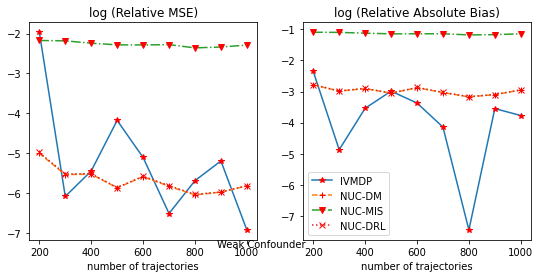

In [16]:
import matplotlib.pyplot as plt
 
trajectory = [200,300,400,500,600,700,800,900,1000]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

#pyl.xlim(0, 20)
#pyl.ylim(0.25, 2)

ax1.plot(trajectory, np.log(MSE_IVRL_DR/eta_pi_true**2)[1:11] ,marker='*', linestyle='-', mec='r', mfc='r', label='IVMDP')
ax1.plot(trajectory, np.log(MSE_DM/eta_pi_true**2)[1:11] ,marker='+', linestyle='--', mec='r', mfc='r', label='DM')
ax1.plot(trajectory, np.log(MSE_MIS/eta_pi_true**2)[1:11] ,marker='v', linestyle='-.', mec='r', mfc='r', label='MIS')
ax1.plot(trajectory, np.log(MSE_DRL/eta_pi_true**2)[1:11] ,marker='x', linestyle=':', mec='r', mfc='r', label='DRL')
ax1.set_xlabel("number of trajectories")
ax1.set_title('log (Relative MSE)')

ax2.plot(trajectory, np.log(abs(Bias_IVRL_DR)/abs(eta_pi_true))[1:11],marker='*', linestyle='-', mec='r', mfc='r', label='IVMDP')
ax2.plot(trajectory, np.log(abs(Bias_DM)/abs(eta_pi_true))[1:11],marker='+', linestyle='--', mec='r', mfc='r', label='NUC-DM')
ax2.plot(trajectory, np.log(abs(Bias_MIS)/abs(eta_pi_true))[1:11],marker='v', linestyle='-.', mec='r', mfc='r', label='NUC-MIS')
ax2.plot(trajectory, np.log(abs(Bias_DRL)/abs(eta_pi_true))[1:11],marker='x', linestyle=':', mec='r', mfc='r', label='NUC-DRL')
ax2.set_xlabel("number of trajectories")
ax2.set_title('log (Relative Absolute Bias)')
#plt.legend(loc=(1.05,0.4))
plt.legend(loc="best")
plt.text(0, -8, "Weak Confounder", ha='center')
#plt.xlim(399, 1001)
plt.show()